# Google Stock Price Prediciton - LSTM Time Series Prediction

This project builds a LSTM-based RNN prediction model to predict the Google stock price using stock price data from 2004-2020.

## Part 1 - Data Preprocessing

### Importing the libraries

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing dataset

In [57]:
google = pd.read_csv('GOOGL.csv')
google.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300


In [58]:
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4041 entries, 0 to 4040
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4041 non-null   object 
 1   Open       4041 non-null   float64
 2   High       4041 non-null   float64
 3   Low        4041 non-null   float64
 4   Close      4041 non-null   float64
 5   Adj Close  4041 non-null   float64
 6   Volume     4041 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 221.1+ KB


### Split training and validation set

Here I used open stock price from 2008-2019 to train the model and predicted the trend of the stock price for 2020. Note that the future variations of the stock price are independent from the past, so it's impossible to predict the exact future stock price. The goal is to capture the downward and upward trends in Google stock price.

In [59]:
from datetime import datetime
google['Date'] = google['Date'].apply(lambda x: datetime.date(datetime.strptime(x , '%Y-%m-%d')))


In [60]:
dataset_train = google.query("Date<datetime.date(datetime.strptime('2020-01-01', '%Y-%m-%d'))")
dataset_test = google.drop(dataset_train.index)

In [61]:
training_set = dataset_train.iloc[:, 1:2].values

### Feature Scaling

Normalization is recommended in training Neural Network, if there is a sigmoid function as the activation function
in the output layer of you recurrent neural network.

In [62]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Creating a data structure with 60 timesteps and 1 output

It's super important to have the right number of time steps because a wrong number of time steps could lead to over fitting or nonsense predictions.I've tried [10,20,30,40,50,60,90] timesteps, and found 60 which corresponds to three months is the optimal.

A special data structure is needed to cover 60-time stamps, based on which RNN will predict the 61st price.

In [65]:
X_train = []
y_train = []
for i in range(60,training_set.shape[0]) :
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [66]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [67]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [68]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

Tried 50 nerons in the first LSTM layer to have high dimensionality to capture the trends.Hypertunning drop-out rate to improve the model fit.

In [69]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

### Adding additional LSTM layers to create stacked LSTM model

In [70]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [71]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [72]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [73]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [74]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [75]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
120/120 [==============================] - 9s 72ms/step - loss: 0.0081
Epoch 2/100
120/120 [==============================] - 9s 73ms/step - loss: 0.0024
Epoch 3/100
120/120 [==============================] - 9s 72ms/step - loss: 0.0022
Epoch 4/100
120/120 [==============================] - 9s 72ms/step - loss: 0.0019
Epoch 5/100
120/120 [==============================] - 9s 72ms/step - loss: 0.0017
Epoch 6/100
120/120 [==============================] - 9s 72ms/step - loss: 0.0017
Epoch 7/100
120/120 [==============================] - 9s 79ms/step - loss: 0.0018
Epoch 8/100
120/120 [==============================] - 9s 73ms/step - loss: 0.0015
Epoch 9/100
120/120 [==============================] - 9s 73ms/step - loss: 0.0014
Epoch 10/100
120/120 [==============================] - 9s 73ms/step - loss: 0.0013
Epoch 11/100
120/120 [==============================] - 9s 74ms/step - loss: 0.0015
Epoch 12/100
120/120 [==============================] - 9s 73ms/step - loss: 0.0013
E

120/120 [==============================] - 9s 75ms/step - loss: 5.8240e-04
Epoch 95/100
120/120 [==============================] - 10s 80ms/step - loss: 6.4416e-04
Epoch 96/100
120/120 [==============================] - 13s 106ms/step - loss: 6.1490e-04
Epoch 97/100
120/120 [==============================] - 10s 79ms/step - loss: 6.0914e-04
Epoch 98/100
120/120 [==============================] - 10s 81ms/step - loss: 7.4264e-04
Epoch 99/100
120/120 [==============================] - 9s 78ms/step - loss: 0.0012
Epoch 100/100
120/120 [==============================] - 9s 79ms/step - loss: 5.8990e-04


## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2020

In [76]:

real_stock_price = dataset_test.iloc[:, 1:2].values

In [79]:
real_stock_price.shape

(172, 1)

In [82]:
dataset_total.shape

(4041,)

### Getting the predicted stock price of 2020

In [83]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, real_stock_price.shape[0]+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualising the results

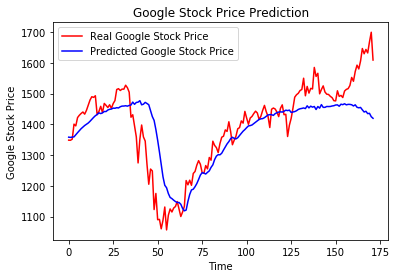

In [97]:
#plt.figure(figsize=(15,10),dpi=100)
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [90]:
from math import *
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 86.61


As the line graph shows, prediction lags behind the real values, because the model cannot react fast to non-linear changes. But on the other hand, the model reacts well to smooth changes. So, we conclude in parts of prediction which contain spikes, the model lags behind the actual prices, but the parts that contain smooth changes, the model manages to follow upwards and downward trends.